# Análisis de la generación de preguntas de un tema

In [1]:
from openai import OpenAI
import os
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import string
import requests

In [2]:
load_dotenv()
apiKey = os.getenv("API_KEY")
client_openai = OpenAI(api_key=apiKey)

size = 160

API_DIR = 'gpt-3.5-turbo'
GENERATE_DIR = 'ft:gpt-3.5-turbo-0125:tfg:pruebapreguntas9:9KUIXy4j'
WIKIPEDIA_DIR = 'https://en.wikipedia.org/w/rest.php/v1/search/page?q='

Temas a generar: se elige uno muy amplio, otro más concreto y otro específico.

In [7]:
themes = ['Computers', 'Social media', 'Instagram']
random_letters = random.choices(string.ascii_lowercase, k=size)
random_letters = [letter for letter in random_letters if letter not in ['w', 'k']]
len(random_letters)

149

### Funciones para generar las preguntas

In [21]:
def generate_words_theme(themes, model, function, temp=1.1, max_tokens = 10, random_letters=random_letters):
	words = {}
	for theme in tqdm(themes, desc='Generating words'):
		words_theme = []
		for letter in random_letters:
			prompt = function(letter, theme)
			response = client_openai.chat.completions.create(
				model=model,
				messages=[
					{'role': 'user', 'content': prompt}
				],
				temperature = temp,
				max_tokens = max_tokens
			)
			words_theme.append((letter, response.choices[0].message.content))
		words[theme] = words_theme
	return words

def generate_desc_words(words, model, function, temp=1.1, max_tokens = 50):
	desc_words = {}
	for theme in tqdm(themes, desc='Generating descriptions'):
		desc_words_theme = []
		for letter, word in words[theme]:
			prompt = function(word, theme)
			response = client_openai.chat.completions.create(
				model=model,
				messages=[
					{'role': 'user', 'content': prompt}
				],
				temperature = temp,
				max_tokens = max_tokens
			)
			desc_words_theme.append((letter, word, response.choices[0].message.content))
		desc_words[theme] = desc_words_theme
	return desc_words

### Funciones para medir la calidad de las preguntas

In [22]:
def valid_words(words, themes):
	not_valid ={theme: 0 for theme in themes}

	for theme in themes:
		for letter, word in words[theme]:
			if (letter.lower() not in word.lower()) or (" " in word):
				not_valid[theme] += 1
				print(f"Error: \'{word}\' not valid for \'{letter}\'")
			wiki = WIKIPEDIA_DIR + word.lower()
			resp = requests.get(wiki)
			if resp.status_code != 200:
				not_valid[theme] += 1
				print(f"Error: \'{word}\' not found in Wikipedia")
	
	for theme in themes:
		not_valid[theme] = round((not_valid[theme] / len(words[theme]))*100, 2)
	return not_valid

def valid_descs(descs, themes, function):
	not_accurate ={theme: 0 for theme in themes}
	not_valid = {theme: 0 for theme in themes}

	for theme in themes:
		for letter, word, desc in descs[theme]:
			if word.lower() in desc.lower():
				not_valid[theme] += 1
				break
			promptDesc = function(word, desc, theme)
			response = client_openai.chat.completions.create(
				model=API_DIR,
				messages=[
					{'role': 'user', 'content': promptDesc}
				],
				temperature = 0.5,
				max_tokens = 2
			)
			if response.choices[0].message.content.lower() == 'no':
				not_accurate[theme] += 1
				print(f"\'{word}\' - \'{desc}\' not related to \'{theme}\' or not valid")
			elif response.choices[0].message.content.lower() != 'yes':
				print('Error:', response.choices[0].message.content)
	
	for theme in themes:
		not_valid[theme] = round((not_valid[theme] / len(descs[theme]))*100, 2)
		not_accurate[theme] = round((not_accurate[theme] / len(descs[theme]))*100, 2)
	return not_valid, not_accurate

### Funciones para mostrar los gráficos

In [29]:
def generate_words_chart(metrics_api, metrics_model):
	bars_api = [(100 - metrics_api[theme]) for theme in themes]
	bars_model = [(100 - metrics_model[theme]) for theme in themes]

	plt.figure(figsize=(8, 6))
	bar_width = 0.35
	index = range(len(themes))
	plt.bar(index, bars_api, bar_width, label='API', color='dodgerblue')
	plt.bar([i + bar_width for i in index], bars_model, bar_width, label='Modelo', color='red')
	plt.xlabel('Tema')
	plt.ylabel('Palabras válidas (%)')
	plt.title('Palabras válidas por tema y modelo (de más general a más específico)')
	plt.xticks([i + bar_width / 2 for i in index], themes)
	plt.legend()
	# plt.ylim(0, 130) 

	for i, (bar_api, bar_model) in enumerate(zip(bars_api, bars_model)):	
		plt.text(i, bar_api +0.2, f'{bar_api}%', ha='center', color='black')
		plt.text(i + bar_width, bar_model+0.2, f'{bar_model}%', ha='center', color='black')

	plt.tight_layout()

def generate_descs_chart(not_valid_desc, not_acc_desc, title):
	bars_not_valid = [not_valid_desc[theme] for theme in themes]
	bars_acc = [not_acc_desc[theme] for theme in themes]

	plt.figure(figsize=(8, 4))
	bar_width = 0.35
	index = range(len(themes))
	plt.bar(index, bars_not_valid, bar_width, label='Contiene la palabra', color='forestgreen')
	plt.bar([i + bar_width for i in index], bars_acc, bar_width, label='Mala descripción', color='cornflowerblue')
	plt.xlabel('Tema')
	plt.ylabel('Descripciones no válidas (%)')
	plt.title('Descripciones no válidas por tema de' + title)
	plt.xticks([i + bar_width / 2 for i in index], themes)
	plt.legend()
	plt.ylim(0, 50) 

	for i, (bar_not_valid, bar_acc) in enumerate(zip(bars_not_valid, bars_acc)):	
		plt.text(i, bar_not_valid + 0.1, f'{bar_not_valid}%', ha='center', color='black')
		plt.text(i + bar_width, bar_acc+0.1, f'{bar_acc}%', ha='center', color='black')

	plt.tight_layout()

## API de OpenAI sin entrenar

Primero se saca una palabra con ese tema, luego una definición para esa palabra.

In [24]:
def promp_question_api(letter, theme):
	return f'Generate only, without any unnecessary message and without punctuation, a word that exists in English, that starts with the letter {letter} that has to do with {theme}\n'
 
def prompt_desc_api(word, theme):
	return f'Generate a definition of the word "{word}" in 20 words without saying "{word}". Include essential information about its meaning and common use. It has to do with {theme}\n'

def prompt_valid_desc(word, desc, theme):
	return f'Now: Answer only "yes" or "no": is \'{desc}\' a description for \'{word}\' related to {theme}?\n'

In [ ]:
words = generate_words_theme(themes, API_DIR, promp_question_api)
not_valid_api = valid_words(words, themes)

In [ ]:
descriptions = generate_desc_words(words, API_DIR, prompt_desc_api)
not_valid_desc_api, not_accurate_desc_api = valid_descs(descriptions, themes, prompt_valid_desc)

Generating descriptions: 100%|██████████| 3/3 [07:35<00:00, 152.00s/it]


## Modelo entrenado

In [ ]:
def prompt_generate_model(letter, theme):
	return f"Give me a single word that starts with or contains the letter \'{letter}\' that is related to {theme}. Provide a concise definition (also related to {theme}) and difficulty (Easy, Medium or Hard)"

In [ ]:
questions = generate_words_theme(themes, GENERATE_DIR, prompt_generate_model, temp=0.8, max_tokens=50)

Generating words: 100%|██████████| 3/3 [06:19<00:00, 126.37s/it]


In [ ]:
words_model = {theme: [(letter, word.split('|')[0].strip()) for letter, word in questions[theme]] for theme in themes}
not_valid_model = valid_words(words_model, themes)

descriptions_model = {theme: [(letter, word.split('|')[0].strip(), word.split('|')[1].strip()) for letter, word in questions[theme]] for theme in themes}
not_valid_desc_model, not_accurate_desc_model = valid_descs(descriptions_model, themes, prompt_valid_desc)

## Resultados

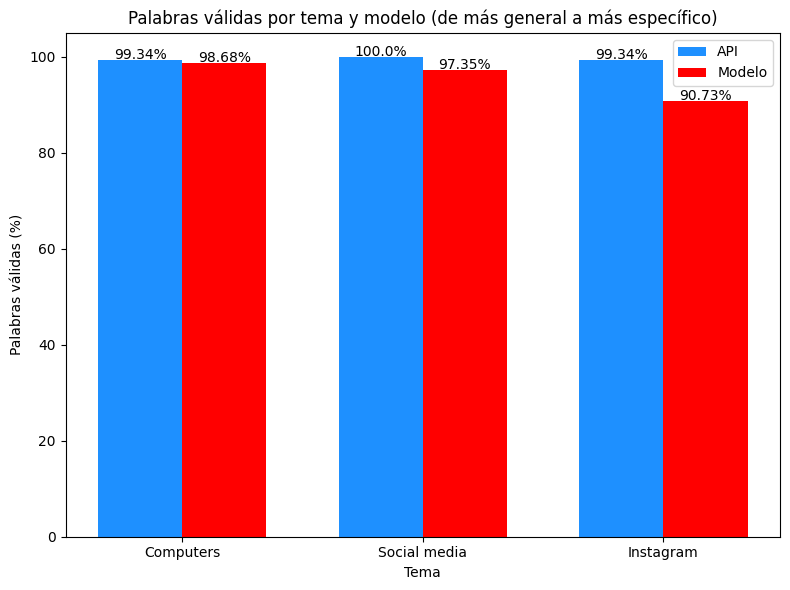

In [30]:
generate_words_chart(not_valid_api, not_valid_model)

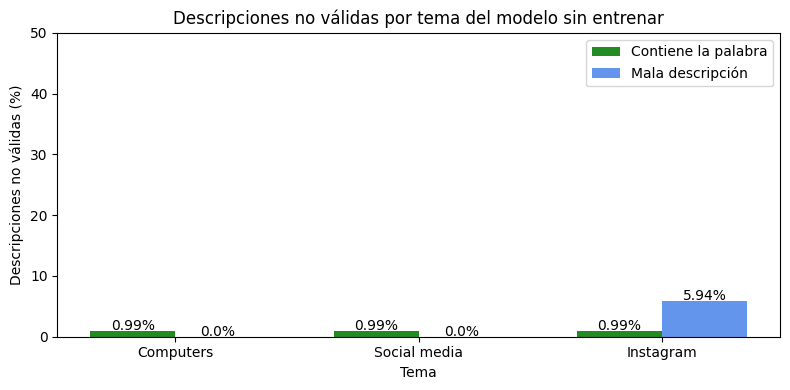

In [ ]:
generate_descs_chart(not_valid_desc_api, not_accurate_desc_api, "l modelo sin entrenar")

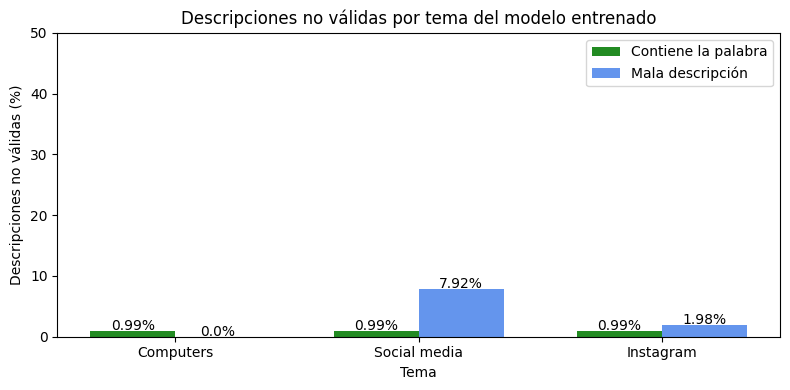

In [ ]:
generate_descs_chart(not_valid_desc_model, not_accurate_desc_model, "l modelo entrenado")